In [ ]:
# all shut down to restart kernel
import os
os._exit(00)

# **Environment setting**

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

In [ ]:
import os
!ls
%cd /content/drive/Colab/unet
%ls
!pip install imagecodecs

# **Code part**

## **train**

In [ ]:
!python3 train.py

## **predict**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from data import get_train_val

# --------------------------------------- #
# Step 1: Load Model and Make Predictions #
# --------------------------------------- #

images, labels = get_train_val(split=0) # train
test_images = get_train_val(data='test')
# plt.imshow(np.squeeze(labels)[0], 'gray')
# plt.show()

model_fname = 'DIC_seg_ST_model_toy_a4.h5'
model = keras.models.load_model(model_fname)

# probs = np.squeeze(model.predict(images[:10]))  # (n, 512, 512, 1)
probs = np.squeeze(model.predict(test_images))

# print(probs.shape)
print(np.amin(probs)) # lowest prob
print(np.amax(probs)) # highest prob

# below is for tracking
# for i, prob in enumerate(probs):
#     # print(f'center {i+1}', prob[256, 256])
#     predict = np.argmax(prob, axis=2)
#     predictions.append(predict)

# predictions = [np.where(prob > 0.34, 1, 0) for prob in probs]

# plt.imshow(predictions[0], 'gray')
plt.imshow(probs[0], 'gray')
plt.show()
print(len(probs))
print(probs.shape)
#print(probs[0])

In [ ]:
model_fname = 'DIC_track_model_toy_a4.h5'
model = keras.models.load_model(model_fname)

# probs = np.squeeze(model.predict(images[:10]))  # (n, 512, 512, 1)
probs_marker = np.squeeze(model.predict(test_images))

# print(probs.shape)
print(np.amin(probs_marker)) # lowest prob
print(np.amax(probs_marker)) # highest prob

# below is for tracking
# for i, prob in enumerate(probs):
#     # print(f'center {i+1}', prob[256, 256])
#     predict = np.argmax(prob, axis=2)
#     predictions.append(predict)

# predictions = [np.where(prob > 0.34, 1, 0) for prob in probs]

# plt.imshow(predictions[0], 'gray')
plt.imshow(probs_marker[0], 'gray')
plt.show()
print(len(probs_marker))
print(probs_marker.shape)
#print(probs_marker)

## **save images**

In [ ]:
import skimage.io as io
import skimage.transform as trans

def save_img(prob_array, save_path, img_num, first_index):
  for i in range(img_num):
    if 0<=i<=9:
      io.imsave(os.path.join(save_path+"t00"+str(i)+"_predict.tif"),prob_array[first_index+i])
    elif 10<=i<=99:
      io.imsave(os.path.join(save_path+"t0"+str(i)+"_predict.tif"),prob_array[first_index+i])
    elif i>=100:
      io.imsave(os.path.join(save_path+"t"+str(i)+"_predict.tif"),prob_array[first_index+i])

save_img(probs,"/content/drive/Colab/",len(probs),0)

# save predictions
save_img(probs,"/content/drive/Colab/predict/s1/",84,0)
save_img(probs,"/content/drive/Colab/predict/s2/",84,84)
save_img(probs,"/content/drive/Colab/predict/s3/",115,168)
save_img(probs,"/content/drive/Colab/predict/s4/",115,283)

save_img(probs_marker,"/content/drive/Colab/predict/m1/",84,0)
save_img(probs_marker,"/content/drive/Colab/predict/m2/",84,84)
save_img(probs_marker,"/content/drive/Colab/predict/m3/",115,168)
save_img(probs_marker,"/content/drive/Colab/predict/m4/",115,283)


## **drawcounter**

### import

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

### read raw, predict, marker images

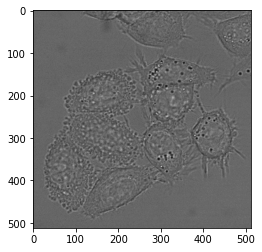

In [5]:
def contrast_stretch(img):
    MIN, MAX = np.amin(img), np.amax(img)
    return np.uint8((img - MIN) * 255/(MAX - MIN))

img = cv2.imread('/content/drive/Colab/data/t000.tif',-1)
plt.imshow(img,'gray')
plt.show()

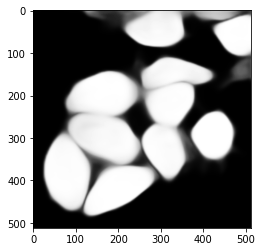

[[0.0925841  0.0303538  0.02505711 ... 0.29323196 0.3050265  0.3571114 ]
 [0.04485638 0.01979021 0.01674217 ... 0.25151244 0.26561415 0.30663314]
 [0.02822392 0.01550855 0.01277106 ... 0.24555346 0.2641172  0.30250993]
 ...
 [0.02256708 0.0129744  0.01111561 ... 0.00483067 0.00658403 0.00527811]
 [0.03977404 0.02253634 0.01869482 ... 0.00812141 0.01219594 0.01366135]
 [0.1086885  0.05640616 0.0397325  ... 0.01745651 0.0316459  0.06261975]]

pre_float:
[[23.60894445  7.74021791  6.38956186 ... 74.77415085 77.78175786
  91.06340557]
 [11.43837707  5.04650351  4.26925284 ... 64.13567171 67.73160875
  78.19145188]
 [ 7.19709881  3.95467936  3.25662071 ... 62.61613324 67.34988883
  77.1400331 ]
 ...
 [ 5.75460644  3.30847273  2.83448094 ...  1.23181992  1.67892768
   1.34591699]
 [10.14237966  5.74676746  4.76718002 ...  2.07096036  3.10996521
   3.48364476]
 [27.71556839 14.38357148 10.13178678 ...  4.45140889  8.06970393
  15.96803516]]

pre_uint:
[[23  7  6 ... 74 77 91]
 [11  5  4 ... 6

In [6]:
pre = cv2.imread('/content/drive/Colab/data/t000_predict.tif',-1)
plt.imshow(pre,'gray')
plt.show()
print(pre)

pre_float = np.zeros((512,512),float)
for i in range(512):
  for j in range(512):
    pre_float[i][j] = pre[i][j] *255

# convert to float and uint8 format
print("\npre_float:")
#print(pre_float.shape)
print(pre_float)
#plt.imshow(pre_float,'gray')
#plt.show()

print("\npre_uint:")
pre_uint = pre_float.astype(np.uint8)
#print(pre_uint.shape)
print(pre_uint)
#plt.imshow(pre_uint,'gray')
#plt.show()

### morphological transformations
https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

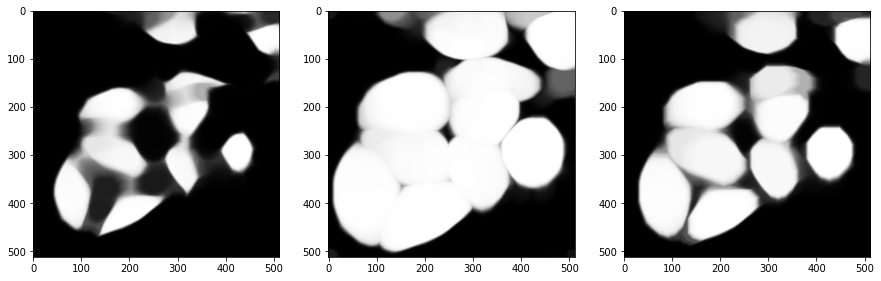

In [16]:
# preprocessing of predict [erosion, dilation, opening]

#kernel = np.ones((7,7),np.uint8) 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))

erosion = cv2.erode(pre_float,kernel,iterations= 3)
dilation = cv2.dilate(pre_float,kernel,iterations= 3)
opening = cv2.morphologyEx(pre_float,cv2.MORPH_OPEN,kernel,iterations= 5)

plt_list = [erosion,dilation,opening]
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(erosion,'gray')
plt.subplot(132)
plt.imshow(dilation,'gray')
plt.subplot(133)
plt.imshow(opening,'gray')
plt.show()


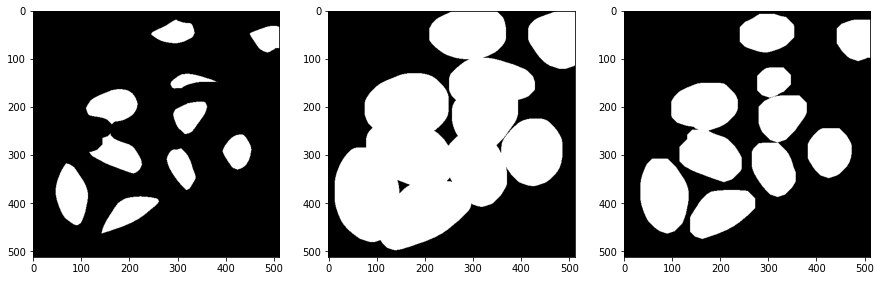

In [17]:
# threshold results [erosion, dilation, opening]
ret, thresh1 = cv2.threshold(erosion, 230, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(dilation, 230, 255, cv2.THRESH_BINARY)
ret, thresh3 = cv2.threshold(opening, 230, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(thresh1,'gray')
plt.subplot(132)
plt.imshow(thresh2,'gray')
plt.subplot(133)
plt.imshow(thresh3,'gray')
plt.show()

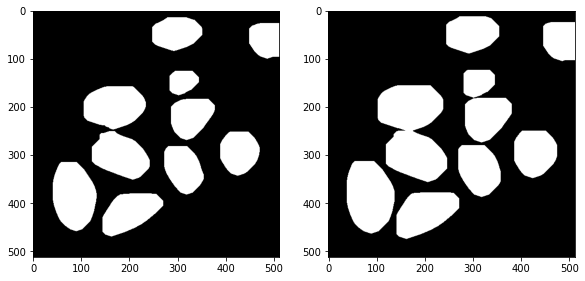

In [36]:
# take thresh3 above(opening)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))

# methon1: dilation(erosion()) (with different interations)
erosion2 = cv2.erode(thresh3,kernel,iterations = 3)
dilation2 = cv2.dilate(erosion2,kernel,iterations = 2)

# methon2: opening
opening2 = cv2.morphologyEx(thresh3,cv2.MORPH_OPEN, kernel, iterations=5)

plt.figure(figsize=(15,8))
#plt.subplot(131)
#plt.imshow(erosion2,'gray')
plt.subplot(132)
plt.imshow(dilation2,'gray')
plt.subplot(133)
plt.imshow(opening2,'gray')
plt.show()

In [ ]:
draw contours

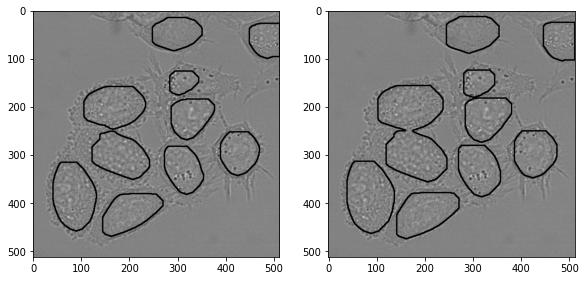

In [41]:
# img2, contours, hierarchy
contours1, _ = cv2.findContours(dilation2.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(opening2.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

out1 = img.copy()
cv2.drawContours(out1,contours1,-1,(0,191,255),2)
out2 = img.copy()
cv2.drawContours(out2,contours2,-1,(0,191,255),2)

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(out1,'gray')
plt.subplot(132)
plt.imshow(out2,'gray')
plt.show()


draw contours (watershed with markers)

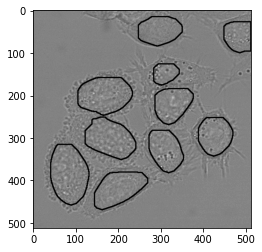

In [42]:
m = cv2.imread('/content/drive/Colab/data/t000_marker.tif',-1)
#plt.imshow(m,'gray')
#plt.show()
thresh = dilation2

distance = ndi.distance_transform_edt(thresh)
local_max = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=thresh)
markers = ndi.label(local_max)[0]
#print(markers)

m_int = np.zeros((512,512),int)
for i in range(512):
  for j in range(512):
    m_int[i][j] = m[i][j] *255

markers = m_int
#print(markers)
#plt.imshow(markers)

ws_labels = watershed(-distance, markers, mask=thresh)
seg = contrast_stretch(ws_labels)

#plt.imshow(-distance)
#plt.imshow(ws_labels)

contours, hierarchy = cv2.findContours(seg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
out = img.copy()
cv2.drawContours(out,contours,-1,(0,191,255),2)
plt.imshow(out,'gray')
plt.show()